In [1]:
from pyspark.sql import SparkSession, functions as F, types as T, DataFrame
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator, RankingEvaluator
from pyspark.ml.feature import StringIndexer
import pyspark.pandas as ps
import association_metrics as am
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List
from scipy.spatial import distance

/Users/alex/PycharmProjects/Pandora_project/venv/lib/python3.8/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
spark = SparkSession.builder \
        .master('local') \
        .appName('myAppName') \
        .config('spark.executor.memory', '5gb') \
        .config("spark.cores.max", "6") \
        .getOrCreate()

23/10/26 02:19:23 WARN Utils: Your hostname, Alejandros-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.43.128 instead (on interface en0)
23/10/26 02:19:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/26 02:19:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/26 02:19:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
product_df = spark.read.parquet('Data/product_.parquet')
orders_df = spark.read.parquet('Data/orders_.parquet')

In [4]:
product_df.head(1)

[Row(category=1, collection=9.0, color=1.0, launch_create_date='2000-Q1', material=1.0, metal_type=2.0, size=253.0, stone=1.0, theme='Not Classified', sub_theme='N/A', product_id_with_size='d0acf752-1cde-4101-b5fc-4b933053ccc7', product_id='fc49edc8-e1a5-4b06-b4d0-287f342928b7', __index_level_0__=0)]

In [5]:
orders_df.head()

Row(quantity=1, dw_ts=datetime.datetime(2023, 1, 7, 0, 0), transaction_number='90250554064', customer_id=None, store_id='ebdbclblco', store_type='Concept Store', order_id='mealaqecklliaekinjickaeokaobkcj', transaction_type=1, gross_value_dkk=5.560953183103123, net_value_dkk=5.543674213091838, product_id_with_size='b0ba151d-6064-4dd9-9e27-a7e4f456b021', product_id='b0ba151d-6064-4dd9-9e27-a7e4f456b021', __index_level_0__=0)

**Problem statement**

As a retail business, “the company” (A) wants to understand their customers better. To achieve this, they intend to use analysis and solutions based on historical data. It can help ‘A’ develop strategies to improve customer and product experience.

The goal of this project is therefore to use the data provided (product_df and orders_df) to build some sort of model which helps with customer experience.

We can find a customer_id in the orders_df, and it seems like the only data we will ever be able to extract at a customer level will be related to amount of spending, types of products bought, etc. I will consider the following problems:
1. Product recommendation
2. Customer segmentation
3. Customer churn prediction

In [6]:
print(f'Oldest record: {orders_df.select(F.min("dw_ts")).first()}')
print(f'Most recent record: {orders_df.select(F.max("dw_ts")).first()}')

Oldest record: Row(min(dw_ts)=datetime.datetime(2023, 1, 1, 0, 0))
Most recent record: Row(max(dw_ts)=datetime.datetime(2023, 1, 31, 0, 0))


The orders data belongs all to the same month (January 2023). Since we are looking at purchases of jewelry items, it is unlikely that we will be able to identify customer behaviour with such a small timeframe, as most customers will not purchase jewelry multiple times in a month. 

<h3>Model discussion</h3>
From my point of view, this immediately rules out the possibility of building a customer churn model. I would have assumed that a churn happens when a customer suddenly changes from a higher frequency of purchases to having no purchases at all, perhaps after a return. But with only one month of data I do not believe it would be possible to label customers as "churned" and "not churned", or identify any index of activity.
<br>
<br>
Additionally, I also find it unlikely to be able to build a reliable customer segmentation model. With only one month of data, there is a very high probability of building biased features. A customer "preferred theme", for instance, will be biased by their January purchases but it is very possible that they would have bought products from many different themes in the past. Seasonality of January in particular might also influence the data, and I believe any type of segmentation at a customer level would be very weak.
<br>
<br>
Finally, it is also a bad scenario for a recommender engine, as customer historical behaviour is lost. We do not know what products the customers were purchasing in the past and which preference they have already shown. Nevertheless, we still know what is "popular" at the current time, and we have very rich product data, which allows for a much more robust "similar product" recommender engine. I focused on the product level, not the product with size, as I understand that customers might choose sizes depending on their own physical characteristics which should be uncorrelated with their taste (ie, two customers who like the same product of different sizes still have the same taste for the purpose of this model).

<h3>Approach taken</h3>
I still wanted to keep in mind the customer preferences, so I have opted to go for two different recommender engines:

1. **Proximity based recommendations** - Given a certain product, the model will identify other products which are the same in certain categories and close in price, popularity, etc... and it will return a list of these "similar" products which the customer might not have seen and might like more.
2. **Collaborative filtering** - A recommender engine based on customer purchases. The idea is that, given different histories of purchases, it will identify "similar customers" and recommend products which you might not have bought but other similar customers to you would have. In practice, given a customer_id it will recommend certain products based on your history.


I considered building these two models and joining the recommendations in some way, but I believe it actually makes more business sense to keep them separate. Some customers might really benefit from having personalised recommendations (collaborative filtering) while others might just be looking for a specific type of product (eg. a necklace) and would be more interested in finding all the similar products quickly.

<h2>Proximity based recommendations</h2>

In [7]:
product_df = product_df.toPandas()

In [8]:
categorical_variables = ['category', 'collection', 'color', 'launch_create_date', 'material', 'metal_type', 'stone', 'theme']
product_df[categorical_variables] = product_df[categorical_variables].astype('category')

In [9]:
cramersv = am.CramersV(product_df)

In [10]:
corr = cramersv.fit()
print(corr)

                    category  collection     color  launch_create_date  \
category            1.000000    0.237848  0.106357            0.246079   
collection          0.237848    1.000000  0.100588            0.313816   
color               0.106357    0.100588  1.000000            0.271150   
launch_create_date  0.246079    0.313816  0.271150            1.000000   
material            0.193354    0.112751  0.168896            0.285780   
metal_type          0.324663    0.245463  0.143397            0.324856   
stone               0.148257    0.126664  0.510195            0.207695   
theme               0.230912    0.249752  0.119793            0.285253   

                    material  metal_type     stone     theme  
category            0.193354    0.324663  0.148257  0.230912  
collection          0.112751    0.245463  0.126664  0.249752  
color               0.168896    0.143397  0.510195  0.119793  
launch_create_date  0.285780    0.324856  0.207695  0.285253  
material          

<Axes: >

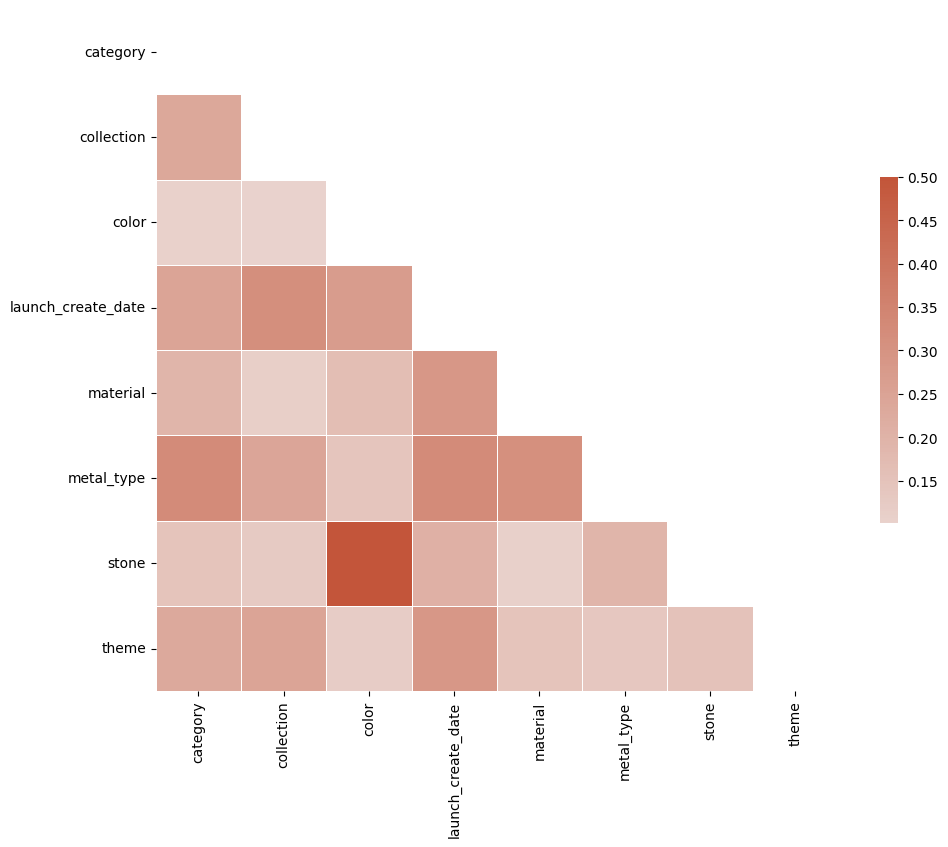

In [11]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<h3>Correlation of categories using Cramer's V</h3>
Cramer's V is a correlation matrix for identifying associations of categorical variables.
The matrix suggests that most categorical features are not as highly correlated to each other as one might think originally. The only obvious association is stone type to color. This means that there are potentially a few products in each categorical combination and it is fair to assume that any combination of categories could be populated.

In [12]:
possible_combinations = 1
for col in categorical_variables:
    n = product_df[col].nunique()
    print(f'Variable "{col}" has {n} possible values')
    possible_combinations *= n
print(f'possible combinations = {possible_combinations}')

Variable "category" has 9 possible values
Variable "collection" has 17 possible values
Variable "color" has 20 possible values
Variable "launch_create_date" has 91 possible values
Variable "material" has 13 possible values
Variable "metal_type" has 24 possible values
Variable "stone" has 61 possible values
Variable "theme" has 12 possible values
possible combinations = 63595808640


With 63595808640 possible combinations of categories, I had to come up with a way to find similar products which would perhaps not be within the exact same categorical bucket. To avoid complex if statements, I decided to use Levenshtein distance. It is a measure of string proximity, which in this case I would apply to categories. 
<br>
Here is an illustration:
1. Lev_distance("ab", "ax") = 1
2. Lev_distance("ab", "abx") = 1
3. Lev_distance("ac", "axy") = 2

With further business context, the weight for certain categories could be adjusted for improved results. However, for this exercise given the low correlations between categorical variables, I decided to proceed with this method.

**Application details**: I converted the "theme" column into a number, to make sure it showed a similar size to all other categorical columns. I ignored the "sub_theme" column and the "launch_create_date".

In [13]:
for col in product_df.columns:
    n = product_df[col].isna().sum()
    l = len(product_df[col])
    print(f'Variable "{col}" has {n} nulls out of {l} values')

Variable "category" has 0 nulls out of 20874 values
Variable "collection" has 1 nulls out of 20874 values
Variable "color" has 1 nulls out of 20874 values
Variable "launch_create_date" has 2 nulls out of 20874 values
Variable "material" has 1 nulls out of 20874 values
Variable "metal_type" has 1 nulls out of 20874 values
Variable "size" has 1 nulls out of 20874 values
Variable "stone" has 1 nulls out of 20874 values
Variable "theme" has 458 nulls out of 20874 values
Variable "sub_theme" has 458 nulls out of 20874 values
Variable "product_id_with_size" has 0 nulls out of 20874 values
Variable "product_id" has 0 nulls out of 20874 values
Variable "__index_level_0__" has 0 nulls out of 20874 values


There only seems to be an issue with nulls for "theme" and "sub_theme" columns. I converted these into a category in itself.

In [14]:
unique_products = product_df['product_id'].nunique()
print(f'Total number of distinct products: {unique_products}.')

Total number of distinct products: 8140.


For numerical features, I considered product size, number of sales and average price of sales. The last two were obtained from the orders_df table. I only focused on sales, as I did not wish to consider returns as relevant for product similarity. To avoid any noise, I removed sales over a certain amount.

For the variable of value in DKK I assumed that, if there were any outliers, the values would be dependent on product type, so removing them would not make much sense. I also understand that purchases might have been made under different conditions, so I took the average value for each product to mitigate bias.

In [15]:
orders_df.head()

Row(quantity=1, dw_ts=datetime.datetime(2023, 1, 7, 0, 0), transaction_number='90250554064', customer_id=None, store_id='ebdbclblco', store_type='Concept Store', order_id='mealaqecklliaekinjickaeokaobkcj', transaction_type=1, gross_value_dkk=5.560953183103123, net_value_dkk=5.543674213091838, product_id_with_size='b0ba151d-6064-4dd9-9e27-a7e4f456b021', product_id='b0ba151d-6064-4dd9-9e27-a7e4f456b021', __index_level_0__=0)

In [16]:
sales = orders_df[orders_df['quantity']>0]
product_amounts = sales[['quantity','product_id']].groupby('product_id').sum()
product_amounts = product_amounts.toPandas()

<Axes: ylabel='Frequency'>

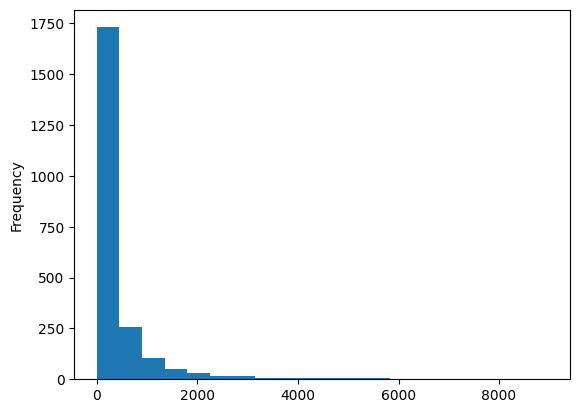

In [17]:
product_amounts = product_amounts[product_amounts['sum(quantity)']<10000]
product_amounts['sum(quantity)'].plot.hist(bins=20)

The distribution suggests that a few products are much more popular than others. I was not too concerned about this as it just means that a customer searching for a popular product will be recommended with greater likelihood another popular product. If recommendations are not satisfactory I would introduce a weight for this parameter or remove it from the model. For this exercise I decided to keep it.

In [18]:
product_values = sales[['gross_value_dkk','product_id']].groupby('product_id').mean()
product_values = product_values.toPandas()

<Axes: ylabel='Frequency'>

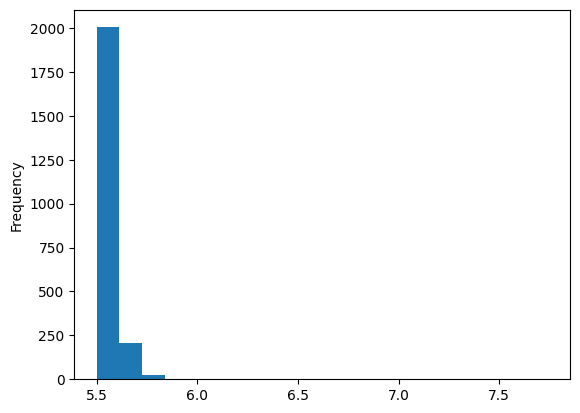

In [19]:
product_values = product_values[product_values['avg(gross_value_dkk)']<10]
product_values['avg(gross_value_dkk)'].plot.hist(bins=20)

I was surprised that there is such a packed distribution for the value of the different products. Perhaps this variable won't be very discriminative when it comes to identifying similar products, but I still thought there was some interest in including it.

<h3>Calculation of distance metrics</h3>

In [20]:
#Initialise data
product_df = spark.read.parquet('Data/product_.parquet')
orders_df = spark.read.parquet('Data/orders_.parquet')
sales = orders_df[orders_df['quantity']>0]

In [21]:
#Find numerical variables from sales data
product_numeric = sales[['product_id','gross_value_dkk']].groupby('product_id').agg(F.mean('gross_value_dkk'), F.count('gross_value_dkk'))
product_numeric = product_numeric.withColumnRenamed(
    'avg(gross_value_dkk)', 'avg_value').withColumnRenamed('count(gross_value_dkk)','sales_amt')

In [22]:
product_data = product_df.join(product_numeric, on='product_id', how='left')

In [23]:
#Set numerical and categorical variables to be used
numerical_features = ['size', 'avg_value', 'sales_amt']
categorical_features = ['category','collection','color','material','metal_type', 'stone', 'theme_id']

In [24]:
#Convert the theme column into a code of similar length to other categories
product_data = product_data.fillna({'theme': 'Null'})
indexer = StringIndexer(inputCol="theme", outputCol="theme_id")
product_data = indexer.fit(product_data).transform(product_data)
product_data = product_data.withColumn('theme_id', F.col('theme_id').cast(T.StringType()))
product_data.head()

Row(product_id='dc43ffbf-2d5a-4a9c-a197-edcb618314a2', category=1, collection=1.0, color=3.0, launch_create_date='2004-Q3', material=1.0, metal_type=4.0, size=200.0, stone=60.0, theme='Nature and Celestial', sub_theme='N/A', product_id_with_size='1572b858-6cf4-4700-8cba-429893552ee0', __index_level_0__=135, avg_value=None, sales_amt=None, theme_id='1.0')

In [25]:
#Create category string
product_data = product_data.withColumn('category_string', F.concat(*[F.col(column) for column in categorical_features]))
product_data.head()

Row(product_id='dc43ffbf-2d5a-4a9c-a197-edcb618314a2', category=1, collection=1.0, color=3.0, launch_create_date='2004-Q3', material=1.0, metal_type=4.0, size=200.0, stone=60.0, theme='Nature and Celestial', sub_theme='N/A', product_id_with_size='1572b858-6cf4-4700-8cba-429893552ee0', __index_level_0__=135, avg_value=None, sales_amt=None, theme_id='1.0', category_string='11.03.01.04.060.01.0')

In [26]:
product_data = product_data.drop('__index_level_0__')
pd_product_data = product_data.pandas_api()

In [30]:
#Extract numerical features, fill nulls and normalise
numeric_product_data = product_data[['product_id'] + numerical_features]
numeric_product_data = numeric_product_data.pandas_api()
for col in numerical_features:
    #A null in sales_amt means that there were no sales in the month of January, so a 0 should be input
    if col=='sales_amt':
        numeric_product_data[col] = numeric_product_data[col].fillna(0)
    #A null in other variables is simply a data quality issue, so I decided to fill it with the mean
    else:
        numeric_product_data[col] = numeric_product_data[col].fillna(numeric_product_data[col].mean())
    numeric_product_data[col] = (numeric_product_data[col] - numeric_product_data[col].mean())/numeric_product_data[col].std()

In [32]:
#Join back into a vector column the numerical features
numeric_product_data = numeric_product_data.to_spark()
numeric_data_vec = numeric_product_data.withColumn('vector',F.array(*[F.col(column) for column in numerical_features]))
product_data_full = product_data.join(numeric_data_vec[['product_id', 'vector']], on='product_id', how='left')
product_data_full.head()

/Users/alex/PycharmProjects/Pandora_project/venv/lib/python3.8/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Row(product_id='dc43ffbf-2d5a-4a9c-a197-edcb618314a2', category=1, collection=1.0, color=3.0, launch_create_date='2004-Q3', material=1.0, metal_type=4.0, size=200.0, stone=60.0, theme='Nature and Celestial', sub_theme='N/A', product_id_with_size='1572b858-6cf4-4700-8cba-429893552ee0', avg_value=None, sales_amt=None, theme_id='1.0', category_string='11.03.01.04.060.01.0', vector=[-0.7227540237150822, 1.2185700293454966e-11, -0.19632705998558558])

In the API implementation, this "product_data_full" table is saved to memory and when a call is done to the API only the following code runs:

In [33]:
#Extract "points" corresponding to the input product
input = '85eda794-f182-4768-94cc-f21d04164d46'
input_product_info = product_data_full.filter(product_data.product_id == input)
input_category_code = input_product_info.rdd.map(lambda x: x['category_string']).collect()[0]
input_vec = input_product_info.rdd.map(lambda x: x['vector']).collect()[0]
print(input_category_code, input_vec)

31.01.01.016.01.00.0 [-1.1651878420289508, 4.037966365638576, -0.09354563261242156]


In [34]:
#Calculate Levenshtein distance from input_category_code to all other product category codes
product_data_lev = product_data_full.withColumn('lev_distance', F.levenshtein(F.lit(input_category_code), F.col('category_string')))

#Calculate Euclidean distance from input_vec to all other product vectors
distance_udf = F.udf(lambda x: float(distance.euclidean(x, input_vec)), T.FloatType())
product_data_lev_euc = product_data_lev.withColumn('euc_distance', distance_udf(F.col('vector')))

product_data_lev_euc.head()

Row(product_id='dc43ffbf-2d5a-4a9c-a197-edcb618314a2', category=1, collection=1.0, color=3.0, launch_create_date='2004-Q3', material=1.0, metal_type=4.0, size=200.0, stone=60.0, theme='Nature and Celestial', sub_theme='N/A', product_id_with_size='1572b858-6cf4-4700-8cba-429893552ee0', avg_value=None, sales_amt=None, theme_id='1.0', category_string='11.03.01.04.060.01.0', vector=[-0.7227540237150822, 1.2185700293454966e-11, -0.19632705998558558], lev_distance=7, euc_distance=4.063432693481445)

In [35]:
#Unify both Levenshtein and Euclidean distance into a single score. This requires normalisation. 
#More weight was given to categorical variables based on correlation and distribution analysis.
pd_spark_data = product_data_lev_euc.pandas_api()
norm_lev_dist = (pd_spark_data['lev_distance'] - pd_spark_data['lev_distance'].mean()) / pd_spark_data['lev_distance'].std()
norm_euc_dist = (pd_spark_data['euc_distance'] - pd_spark_data['euc_distance'].mean()) / pd_spark_data['euc_distance'].std()
w_lev, w_euc = 0.8, 0.2
pd_spark_data['distance'] = w_lev * norm_lev_dist + w_euc * norm_euc_dist

In [36]:
#Using the "distance" column, the closest products can be found. 
#But more negative still means closer to the input product.
other_products = pd_spark_data.loc[pd_spark_data['product_id']!=input]
most_similar = other_products.nsmallest(n=100, columns=['distance'])
recommendations = most_similar[['product_id','lev_distance','euc_distance','distance']].drop_duplicates(subset='product_id').sort_values('distance')
recommendations.head()

,product_id,lev_distance,euc_distance,distance
39583,3b1ef7eb-b0e4-4e8e-b9f9-f9bea3465945,0,1.724855,-3.634021
13520,111464cb-837c-4b86-b4af-a6a45338eb83,0,2.021258,-3.564569
11940,0e4f844c-43b6-4941-9540-4afb4606a545,0,3.135276,-3.303537
31595,31a9c68f-c2a1-4fbe-ba39-95373af154f5,1,0.777330,-3.286837
24043,2265339a-674b-4dfc-94f3-4603d4df4b81,1,1.123456,-3.205734


The actual implementation works with hashed product IDs for efficiency, but converts them back to unhashed when the user accesses the API.
<br>
There is no real way of measuring how effective this model is. The weights given to categorical or numerical features should be adjusted according to user feedback in the form of clicks. More clicks on recommended products is indicative of good model performance, so this variable should be periodically tracked. Additionally, the model can be improved with more variables without significant changes to the pipeline.

<h2>Collaborative filtering</h2>

<Axes: ylabel='Frequency'>

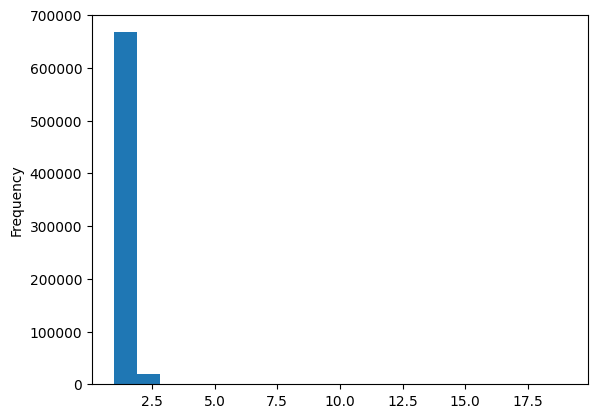

In [37]:
#I wanted to see how many items each customer bought to find a reasonable cap for outliers.
sales_count = sales[['quantity','customer_id', 'product_id']].groupby(['customer_id', 'product_id']).count()
sales_count = sales_count[sales_count['count']<20]
sales_count = sales_count.toPandas()
sales_count['count'].plot.hist(bins=20)

In [38]:
print(sales_count['count'].median() + 3*sales_count['count'].std())

1.8991845600484987


I used mean + 3 * standard deviation to identify outliers. I observed that most customers only bought one copy of a product with a very few exceptions.
This is why I later decided to replace all values with 1, so a customer who purchased a product once or more rated it as 1, if they did
not purchase it, they rated it as a 0

In [39]:
#I find the table of customer id, product id and number of purchases
product_df = spark.read.parquet('Data/product_.parquet')

orders_df_h = orders_df.withColumn('product_id_h', F.hash('product_id'))
orders_df_h = orders_df_h.withColumn('customer_id_h', F.hash('customer_id'))
product_df_h = product_df.withColumn('product_id_h', F.hash('product_id'))

sales_h = orders_df_h[orders_df_h['quantity']>0]

product_list = product_df_h.rdd.map(lambda x: x['product_id_h']).collect()
collected_buys = sales_h[['customer_id_h','product_id_h','quantity']].groupBy(['customer_id_h','product_id_h']).sum('quantity')
collected_buys = collected_buys.filter(collected_buys.product_id_h.isin(product_list))
collected_buys = collected_buys.withColumnRenamed('sum(quantity)', 'quantity')

#First I removed outliers (there was a null product ID and a null customer ID which return many occurrences)
collected_buys = collected_buys.filter(collected_buys.quantity < 6)
#Secondly I replaced all "ratings" by the value 1. All non-entries are already considered by the ALS model as a 0.
collected_buys = collected_buys.withColumn('quantity', F.lit(1))
collected_buys.head()

Row(customer_id_h=1980278576, product_id_h=1633984710, quantity=1)

**Python implementation** <br>
Due to the specifics of the pyspark ALS algorithm, both the customer ID and the product ID had to be integers. I decided to use the pyspark hash function for this purpose. The API implementation unhashes the output back to the original string format.

In [40]:
#20% of the data is left for testing the recommendation engine.
(training, test) = collected_buys.randomSplit([0.8, 0.2])

In [41]:
#The alternating least squares algorithm factorises the user-item interaction matrix. This allows to identify the items for which the
#user is predicted to have a higher rating. This model is very commonly used in recommender engines.
als = ALS(maxIter=15, regParam=0.07, implicitPrefs=False, rank=20, userCol="customer_id_h", itemCol="product_id_h", ratingCol="quantity",
          coldStartStrategy="drop")
model = als.fit(training)


predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="mae", labelCol="quantity",
                                predictionCol="prediction")
mae = evaluator.evaluate(predictions)
print("Mean absolute error = " + str(mae))

23/10/26 02:24:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/26 02:24:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Mean absolute error = 0.07429934962175648


I used Mean Absolute Error to evaluate the model because most distances would be around the values of 0 and 1, so I expect all of the errors to be in absolute value less than 1, for which MAE is more indicative of how well the model is performing.

In [42]:
#Generate top 5 recommendations for each customer
customerRecs = model.recommendForAllUsers(5)

In [43]:
rec = customerRecs.filter(customerRecs.customer_id_h==-2147255615).collect()
recs = rec[0]['recommendations']
for i in range(5):
    print(recs[i]['product_id_h'])

-362837537
-1652476187
-629513671
-950197031
-1403030290


With the data provided it is difficult to evaluate whether these recommendations make sense. The MAE of the model is reasonable, in my opinion (with default parameters I was obtaining values of around 0.5). However, ideally if this model was in production, I would implement a system to track the number of clicks on recommendations. This metric would measure the "success" of the model quite accurately, and one could even implement a champion-challenger mechanism to determine which recommendation engine is more useful.

<h2>Next steps</h2>

Given more time and data I would have tried some of the following ideas:
1. Look at returns of products. I believe some specific products might have been returned with high frequency. These should have been perhaps removed. I would have also removed products from outdated collections, as a shorter product list will speed up the model.
2. With more purchase history I imagine the Collaborative Filtering would be much more accurate. Once a customer profile is built and their purchases are tracked over a few years, the model should be able to pick up much better on customer preferences. A dataset where most customers only buy one product is not a good starting point for this type of model.
3. With additional customer data, the collaborative filtering could be reinforced with other features which allow a mixed algorithm to identify similar customers. Details such as age, sex, location, average yearly spending, etc. would strongly reinforce the model.
4. A wishlist is a commonly used strategy to collect good data regarding customer preferences. This model only uses purchases, but with a wishlist a customer can easily point at 10+ products which they find attratcive.

With regards to the ML engineering implementation, the following details are important for placing this code in production:
1. Tracking number of clicks on recommended products is key to understanding model performance.
2. The sales data used to train the model should be updated periodically and the model should be re-trained.
3. The full pipeline for collaborative filtering should also be unit tested (for illustration purposes I tested proximity matching)
4. For this project I have kept all data in a local folder, but I was not able to upload it to Github due to size. A much cleaner solution would be to save it to a database and this should definitely be done in a production setting.
5. The API is designed to serve one call at a time. There are more robust solutions which allow for calls in parallel up to a large amount. It should also not run in a local machine, but instead be deployed in a virtual machine.